In [1]:
from PIL import Image
import torch
torch.set_printoptions(sci_mode=False)

In [2]:
import platform
import os
if platform.system() == 'Darwin':
    DATA_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync"
    ROOT_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Thesis"
elif platform.system() == 'Linux':
    DATA_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync"
    ROOT_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis"

current_wd = os.getcwd()

In [3]:
os.chdir(f"{ROOT_PATH}/4_Assessor/Dino")
from utils import *
os.chdir(current_wd)

device = set_device()

Using cpu as device


In [4]:
def setup_generator():
    os.chdir(f"{ROOT_PATH}/stylegan2-ada-pytorch")
    # Load model architecture
    experiment_path = f"{DATA_PATH}/Models/Stylegan2_Ada/Experiments/00005-stylegan2_ada_images-mirror-auto2-kimg5000-resumeffhq512/"
    model_name = "network-snapshot-001200.pkl"
    model_path = experiment_path + model_name
    with open(model_path, 'rb') as f:
        architecture = pickle.load(f)
        G = architecture['G_ema']
        D = architecture['D']
    os.chdir(current_wd)
    return G

In [5]:
def plot_generated(img):
    img_perm = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    output = Image.fromarray(img_perm[0].cpu().numpy(), 'RGB')
    return output
def plot_from_latent(latent, G):
    img = G.synthesis(latent, noise_mode='const', force_fp32=True)
    output = plot_generated(img)
    return output


In [6]:
def get_dinov2_embedding(model, processor, img):
    inputs = processor(img)
    inputs = inputs.to(model.device)
    with torch.no_grad():
        output = model(inputs)
        embedding = output['pooler_output']
    return embedding

In [7]:
def get_classifier_score(embedding, model):
        output = model(embedding.to(device))
        scores = torch.softmax(output, 1)
        return scores

### Setup Models

In [8]:
G = setup_generator()
dino = setup_dino_model(device)
classifier = torch.load(f"{DATA_PATH}/Models/Assessor/DinoV2/Classifier/category_restyle.pt", map_location='cpu')

### Check Proper Functioning of all Components

In [9]:
id2label = pickle.load(open("/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis/4_Assessor/Legacy_Code/DinoV2/id2label_dicts/category_id2label.pkl", 'rb'))
id2label

{0: 'Day dress',
 1: 'Jumper dress',
 2: 'Jersey dress',
 3: 'Cocktail dress / Party dress',
 4: 'Maxi dress',
 5: 'Occasion wear',
 6: 'Shift dress',
 7: 'Denim dress'}

In [10]:
sku = 'C5B21C01Z-M11'

#### 1. Scores from Precalculated Embeddings
- This should be exactly the same as in the training of the classifier

In [11]:
precalc_embeddings = torch.load("/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync/Models/Assessor/DinoV2/Embeddings/restyle.pt")
precalc_embedding = precalc_embeddings[sku]
precalc_score = get_classifier_score(precalc_embedding, classifier)
precalc_score

tensor([[    0.2370,     0.0049,     0.5520,     0.1821,     0.0004,     0.0001,
             0.0217,     0.0017]], grad_fn=<SoftmaxBackward0>)

#### 2. Scores from Pre-Generated Image

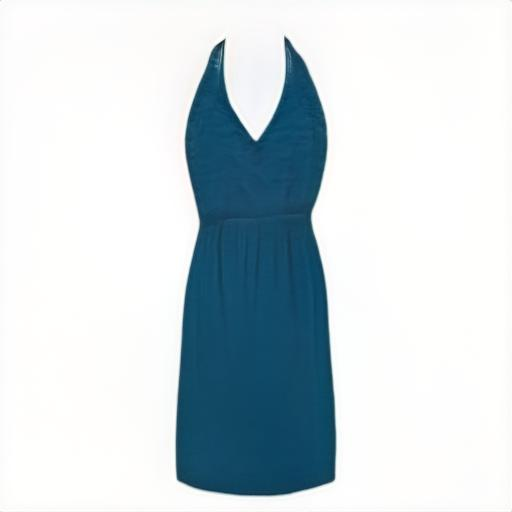

tensor([[    0.2371,     0.0049,     0.5520,     0.1821,     0.0004,     0.0001,
             0.0217,     0.0017]], grad_fn=<SoftmaxBackward0>)

In [41]:
path = f"/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync/Generated_Images/restyle/inference_results/4/{sku}.jpg"
orig = Image.open(path)
display(orig)

pregen_embedding = get_dinov2_embedding(dino, dino_processor, path)
pregen_score = get_classifier_score(pregen_embedding, classifier)
pregen_score

#### 3. Scores from generated image from embeddings

In [32]:
latents = np.load("/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync/Generated_Images/restyle/latents.npy", allow_pickle=True).item()
latent = latents[sku + '.jpg'][4]
latent = torch.Tensor(latent).unsqueeze(0)

gen = G.synthesis(latent, noise_mode='const', force_fp32 = True)
embedding = get_dinov2_embedding(dino, dino_processor, gen)
gen_score = get_classifier_score(embedding, classifier)
gen_score


tensor([[    0.0003,     0.5559,     0.0026,     0.3301,     0.0024,     0.0003,
             0.1056,     0.0027]], grad_fn=<SoftmaxBackward0>)

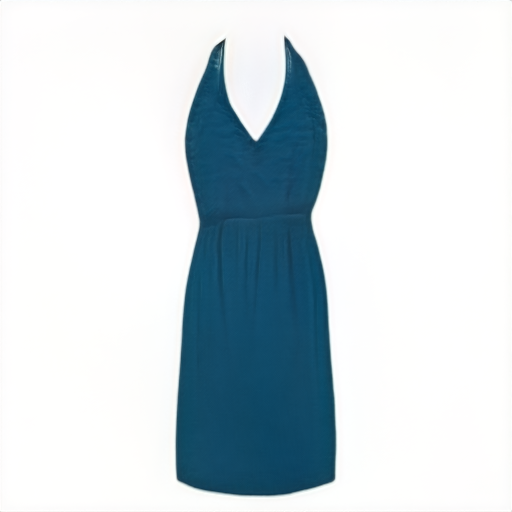

In [42]:
plot_from_latent(latent, G)

In [15]:
img = Image.open(path).convert('RGB')
img = transforms.ToTensor()(img.resize([512,512]))
# img = img.unsqueeze(0)
# processed_img = transform_pipeline(img)

In [16]:
img.min(), img.max()

(tensor(0.), tensor(1.))

In [17]:
gen.min(), gen.max()

(tensor(-0.9592), tensor(1.0538))

In [35]:
gen.shape

torch.Size([1, 3, 512, 512])

### TODO: 
- Search for bug that makes dino embeddings different for generated and loaded images
- There needs to be some post processing of the image before saving
- Check tensor2im method from restyle utils/common.py for possible conversion